In [1]:
import porespy as ps
import numpy as np
from numpy import random
from scipy import stats
import particle_generator as pg

import supervisely_lib as sly
import os
import skimage as ski
from skimage import color
from skimage import exposure
from skimage import transform
from skimage import filters

from matplotlib import pyplot as plt

from supervisely_lib.geometry.bitmap import Bitmap
from supervisely_lib.annotation.annotation import Annotation
from supervisely_lib.annotation.label import Label
from supervisely_lib.annotation.obj_class import ObjClass
from supervisely_lib.project.project_meta import ProjectMeta
from supervisely_lib.geometry.point_location import PointLocation

import scipy.ndimage as spim

In [2]:
# Change this field to the name of your team, where target workspace exists.
team_name = "marcwang17" # Automatically inserted

# Change this field to the of your workspace, where target project exists.
workspace_name = "First Workspace" # Automatically inserted

# Change this field to the name of your target project.
project_name = "synthetic_data" # Automatically inserted

# If you are running this notebook on a Supervisely web instance, the connection
# Edit those values if you run this notebook on your own PC
# details below will be filled in from environment variables automatically.
#
# If you are running this notebook locally on your own machine, edit to fill in the
# connection details manually. You can find your access token at
# "Your name on the top right" -> "Account settings" -> "API token".
address = os.environ['SERVER_ADDRESS']
token = os.environ['API_TOKEN']

In [3]:
# Initialize API object
api = sly.Api(address, token)

In [4]:
team = api.team.get_info_by_name(team_name)
if team is None:
    raise RuntimeError("Team {!r} not found".format(team_name))

workspace = api.workspace.get_info_by_name(team.id, workspace_name)
if workspace is None:
    raise RuntimeError("Workspace {!r} not found".format(workspace_name))
    
print("Team: id={}, name={}".format(team.id, team.name))
print("Workspace: id={}, name={}".format(workspace.id, workspace.name))

Team: id=25454, name=marcwang17
Workspace: id=28720, name=First Workspace


In [5]:
synt_project = api.project.get_info_by_name(workspace.id, project_name)

if synt_project is None:
    synt_project = api.project.create(workspace.id, project_name, change_name_if_conflict=True)
    
    porosity_tag_meta = sly.TagMeta('porosity', sly.TagValueType.ANY_NUMBER)
    
    particle_meta = ObjClass('particle', Bitmap, [255,0,0]) 
    particle_h_meta = ObjClass('particle_h', Bitmap, [0,255,0])
    
    meta = ProjectMeta.from_json(api.project.get_meta(synt_project.id))
    meta = meta.add_obj_class(particle_meta)
    meta = meta.add_obj_class(particle_h_meta)
    
    meta = meta.add_tag_meta(porosity_tag_meta)
    api.project.update_meta(synt_project.id, meta.to_json())
    
else:
    meta = ProjectMeta.from_json(api.project.get_meta(synt_project.id))
    particle_meta = meta.get_obj_class('particle')
    particle_h_meta = meta.get_obj_class('particle_h')
    
    if particle_meta is None:
        particle_meta = ObjClass('particle', Bitmap, [255,0,0])
        meta = meta.add_obj_class(particle_meta)
        
    if particle_h_meta is None:
        particle_h_meta = ObjClass('particle_h', Bitmap, [0,255,0])
        meta = meta.add_obj_class(particle_h_meta)
        
    porosity_tag_meta = meta.get_tag_meta('porosity')
    
    if porosity_tag_meta is None:
        porosity_tag_meta = sly.TagMeta('porosity', sly.TagValueType.ANY_NUMBER)
        meta = meta.add_tag_meta(porosity_tag_meta)
        
    api.project.update_meta(synt_project.id, meta.to_json())

In [6]:
class cb_annotation:
    def __init__(self, ann, obj_class):
        self.labels = ann
        self.ann_type = obj_class
    
    def __call__(self, strel, r, x, y):
        elem = strel.copy()
        x_min = x-r
        y_min = y-r
        origin = PointLocation(x_min, y_min)
        mask = Bitmap(elem, origin)
        
        label_obj = Label(mask, self.ann_type)
        
        self.labels = self.labels.add_label(label_obj)
        
class cb_annotation_h:
    def __init__(self, ann, particle_class, particle_h_class):
        self.labels = ann
        self.ann_type_p = particle_class
        self.ann_type_h = particle_h_class
    
    def __call__(self, strel, ori, hole_bool):
        elem = strel.copy()
        origin = PointLocation(ori[0], ori[1])
        mask = Bitmap(elem, origin)
        
        if(hole_bool):
            label_obj = Label(mask, self.ann_type_h)
        else:
            label_obj = Label(mask, self.ann_type_p)
        
        self.labels = self.labels.add_label(label_obj)

In [7]:
def remap_phase(im, phase_mean, phase_std):
    n_im = np.zeros_like(im, dtype = np.uint16)
    
    void_mask = im == 0
    solid_mask = im == 1
    
    mixed_mask = np.logical_not(np.logical_and(void_mask, solid_mask))
    
    phase_list = np.unique(im[mixed_mask])
    
    n_im[void_mask] = random.normal(phase_mean[0], phase_std[0], 
                                    n_im[void_mask].shape)
    
    n_im[solid_mask] = random.normal(phase_mean[1], phase_std[1], 
                                    n_im[solid_mask].shape)
    
    for mix_ratio in phase_list:
        mix_mask = im == mix_ratio
        
        mix_vector = np.array([1.0 - mix_ratio, mix_ratio])
        
        mean_t = np.dot(mix_vector, phase_mean)
        std_t = np.dot(mix_vector, phase_std)
        
        n_im[mix_mask] = random.normal(mean_t, std_t, n_im[mix_mask].shape)
    
    return n_im
      

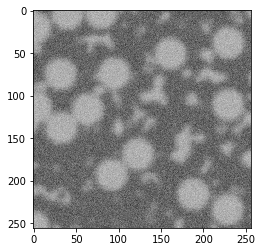

In [8]:
def random_bimodal_pack(dataset, size, n_sample = 10):
    for i in range(n_sample):
        ann = Annotation(size)
        
        cb_func_h = cb_annotation_h(ann, particle_meta, particle_h_meta)
        
        rand_pore = stats.uniform.rvs(loc = 0.4, scale = 0.6 - 0.4)
        
        non_circ_ratio = stats.uniform.rvs(loc = 0.1, scale = 0.2 - 0.1)
        
        big_particle_ratio = (rand_pore - non_circ_ratio)*stats.uniform.rvs(loc = 0.1, scale = 0.6 - 0.1)
        
        holes_ratio = stats.uniform.rvs(loc = 0.1, scale = 0.9 - 0.1)
        blob = stats.uniform.rvs(loc = 0.8, scale = 1.5 - 0.8)
        
        cb_func_h = cb_annotation_h(ann, particle_meta, particle_h_meta)
        non_c_h = pg.non_circular_particle(size, porosity = non_circ_ratio, 
                                           blobiness = blob, holes_p = holes_ratio, 
                                           callback = cb_func_h)
        ann = cb_func_h.labels
        
        big_powder_size = random.randint(30, 70)
        small_powder_size = random.randint(5, 20)
        
        cb_func = cb_annotation(ann, particle_meta)
        big_pack = pg.RSA(non_c_h, big_powder_size, big_particle_ratio, callback = cb_func)
        bimodal_pack = pg.RSA(big_pack, small_powder_size, rand_pore, callback = cb_func)
        
        ann = cb_func.labels
        
        void_phase_mean = stats.uniform.rvs(loc = 50, scale = 130 - 50)
        solid_phase_mean = stats.uniform.rvs(loc = 170, scale = 225 - 170)
        
        void_phase_std = stats.uniform.rvs(loc = 5, scale = 15 - 5)
        solid_phase_std = stats.uniform.rvs(loc = 5, scale = 15 - 5)
        
        mean_phase = np.array([void_phase_mean, solid_phase_mean])
        std_phase = np.array([void_phase_std, solid_phase_std])
        
        sig_blur = random.randint(1,5)

        blurred = np.around(filters.gaussian(bimodal_pack.astype(float), sigma = sig_blur), 2)
        
        grayscale = remap_phase(blurred, mean_phase, std_phase)
        
        real_porosity = np.around(np.mean(bimodal_pack), 3)
        
        pore_tag = sly.Tag(porosity_tag_meta, value=real_porosity)
        
        ann = ann.add_tag(pore_tag)
        
        rgb_im = color.gray2rgb(grayscale)
        
        im_info = api.image.upload_np(dataset.id, 'im_{}.png'.format(i), rgb_im)
        api.annotation.upload_ann(im_info.id, ann)
        
                
dataset = api.dataset.create(synt_project.id, 'trial', change_name_if_conflict=True)
random_bimodal_pack(dataset, (256,256), n_sample = 1)